In [2]:
from autolearner.datasets import SpriteData, SpriteWithQuestions
from autolearner.model import *
from autolearner.config import *

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

train_data = SpriteWithQuestions("train", resolution = (64,64))
train_loader = DataLoader(train_data, batch_size = 3, shuffle= True)

for sample in train_loader:break;
print(sample["image"].shape)

torch.Size([3, 64, 64, 3])


{'program': ['exist(filter(scene(),Circle))', 'exist(filter(scene(),Circle))', 'exist(filter(scene(),Circle))'], 'answer': ['True', 'False', 'True']}
{'program': ['exist(filter(scene(),Cube))', 'exist(filter(scene(),Cube))', 'exist(filter(scene(),Cube))'], 'answer': ['False', 'True', 'True']}
{'program': ['exist(filter(scene(),Diamond))', 'exist(filter(scene(),Diamond))', 'exist(filter(scene(),Diamond))'], 'answer': ['False', 'True', 'True']}
{'program': ['count(scene())', 'count(scene())', 'count(scene())'], 'answer': ['1', '2', '3']}


[None, None, None, None]

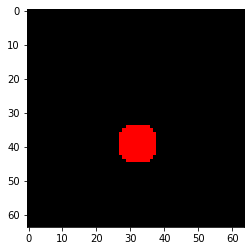

In [92]:
plt.imshow(sample["image"][0])

[print(b) for b in sample["question"]]

constuct a grid convolution model to test the utility of the grouping function $f(x)=\frac{\sum_i x_i^2}{\sum_i x_i}$. The model consists of 1) a grid convolution model that perform gridconv feature extraction 2) a instance tracking model that cluster pixel level information and form the whole. 3) a program executor that learns object centric representation and concept embeddings using query. Specificly, the grid-convolution model first takes the input image $x$ as input, then perform convolution and output the convolution feature denoted as $A_{l} = F(x_{l},\theta)$. Then we use $n$ pre-defined vector keys with same dimension as $A_l$ and use the dot product to calculate the raw mask of pixels. Specifically, the mask use calculated in the form of $m^i_l = \sigma( ( v^T_i \cdot A_l- \gamma) / \tau)$. With these masks over pixels, we use the grouping concreteness function $G(x)$ to perform concreteness evaluation over masks as $s_i = G(m^i_l)$. Then the object centric feature for each slot is calculated as the weighted mean over features of pixels.

In [113]:
from karanir.dklearn import ConvolutionBackbone, ConvolutionUnits

import math

def expat(tens, dim, num):
    rp_tens = tens.unsqueeze(dim)
    rp_shape = [1 for o in rp_tens.shape]
    rp_shape[dim] = num
    output_tensor = rp_tens.repeat(rp_shape)
    return output_tensor

def group_concrete(x, batch = True):
    assert x.min() >= 0.0,print("invalid x < 0.0")
    assert x.min() <= 1.0,print("invalid x > 1.0")
    if batch:
        x_square = x * x
        concrete_scores = x_square.sum(-1).sum(-1) / x.sum(-1).sum(-1)
        return concrete_scores
    return 

class NeuroGrouper(nn.Module):
    def __init__(self, n_slots = 4, feature_dim = 32):
        super().__init__()
        # [1] the Grid Convolution Model
        self.grid_conv = ConvolutionUnits(3, feature_dim, 128)

        # [2] the Instance Sort Model
        self.keys = nn.Parameter(torch.randn([n_slots, feature_dim]))

        # [3] Neuro-Symolic Executor
        self.executor = SceneProgramExecutor(config)
    
    def forward(self, im):
        outputs = {}

        B, W, H, C = im.shape
        im = im.permute(0,3,1,2) #BxCxWxH
        grid_feature = self.grid_conv(im) #BxDxWxH
        key_feature = expat(self.keys,0,B) # BxNxD

        # [Calculate Mask Over]
        raw_masks = torch.einsum("bnd,bdwh->bnwh",key_feature, grid_feature)/ (math.sqrt(W*H))
        masks = torch.softmax(raw_masks, dim = 1) # [BNWH]
        B, N, W, H = masks.shape

        scores = group_concrete(masks)

        outputs["scores"] = scores
        outputs["masks"] = masks

        masked_features = expat(grid_feature.permute(0,2,3,1), 1, N) * masks.unsqueeze(-1)
        outputs["features"] = torch.mean(torch.mean(masked_features,dim = -2), dim = -2)

        return outputs



In [123]:
# [Train the Segmentation Modle]

def train(model, dataset, epochs = 100, ckpt_itrs = 20):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_loader = DataLoader(dataset, batch_size = 3, shuffle= True)
    itr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
    for epoch in range(epochs):
        for sample in train_loader:
            outputs = model(sample["image"].to(device))

            masks = outputs["masks"]
            B, N, W, H = masks.shape
            scores = outputs["scores"]
            features = outputs["features"]

            loss = 0.0

            for b in range(B):
                qa_pairs = sample["question"][b]
                programs = qa_pairs["program"]
                answers = qa_pairs["answer"]

                kwargs = {
                    "end":[scores[b]],
                    "features":[features[b]]}
                for i,p in enumerate(programs):
                    q = model.executor.parse(p)
                    o = model.executor(q,**kwargs)
                    if answers[i] == "True":
                        loss -= torch.log(torch.sigmoid(o["end"]))
                    else: loss +=  torch.log(1 - torch.sigmoid(o["end"]))


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if itr % ckpt_itrs == 0:
                masks = outputs["masks"].detach().numpy()
                scores = outputs["scores"].detach().numpy() # [BxN]
                B, N, W, H = masks.shape
                plt.figure("masks")
                for b in range(B):
                    for n in range(N):
                        plt.subplot(B,N,N * b + n + 1);plt.cla()
                        plt.imshow(masks[b,n,:,:], cmap="bone")
                plt.figure("scores")
                for b in range(B):
                    plt.subplot(B,1,b+1); plt.cla()
                    plt.bar(list(range(len(scores[b]))),scores[b])
            plt.show()
            itr += 1
        break
    

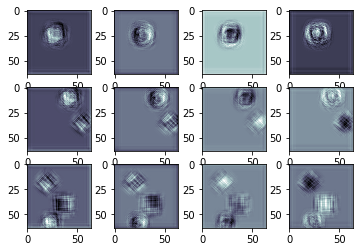

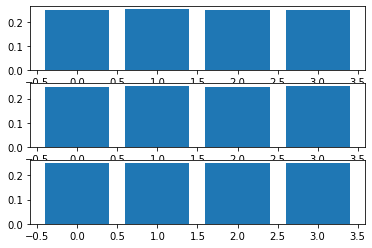

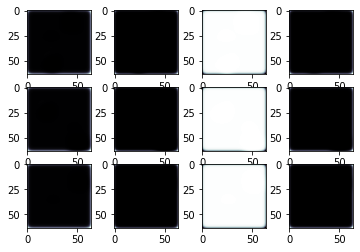

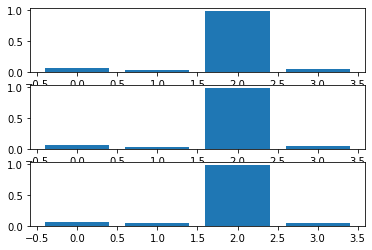

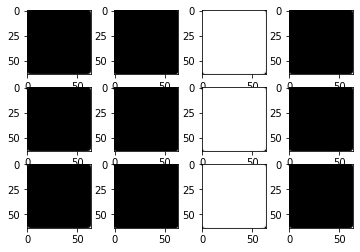

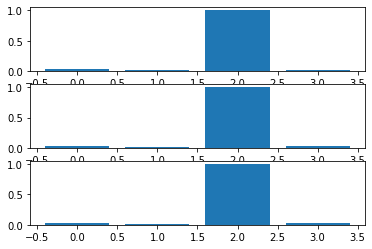

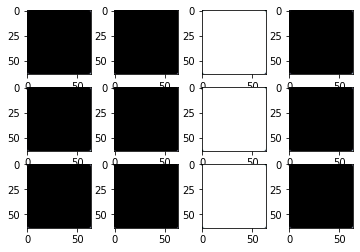

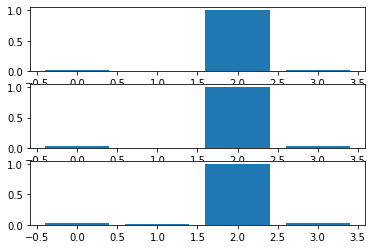

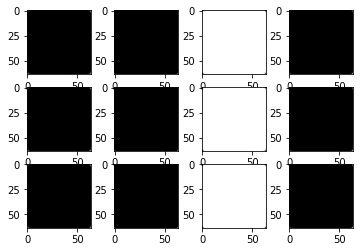

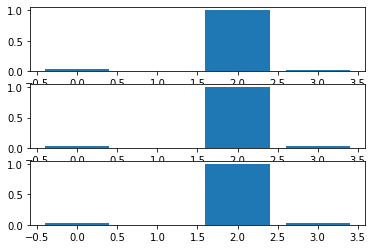

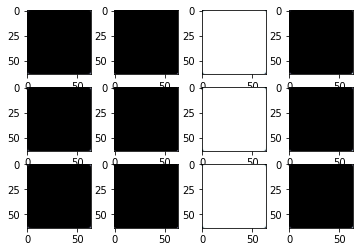

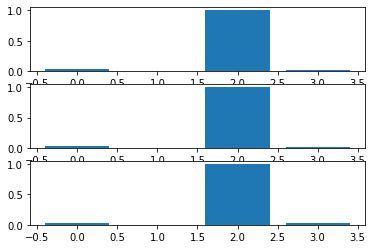

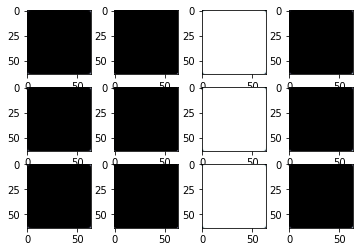

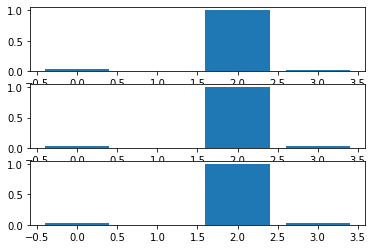

KeyboardInterrupt: 

In [124]:
config.domain = "sprites"
config.concept_dim = 64
config.concept_type = "cone"
grouper = NeuroGrouper(4, config.concept_dim )
train(grouper, train_data)